In [1]:
import json
import pandas as pd
import numpy as np
import re

In [2]:
file_dir = "C:/Users/azinc/Github/Movies-ETL/"

filename = 'wikipedia-movies.json'


In [3]:
with open(f'{filename}', mode='r') as file:
    wiki_movies_raw = json.load(file)
    
len(wiki_movies_raw)

7311

In [4]:
wiki_movies_raw[7200]

{'url': 'https://en.wikipedia.org/wiki/Puzzle_(2018_film)',
 'year': 2018,
 'imdb_link': 'https://www.imdb.com/title/tt6933454/',
 'title': 'Puzzle',
 'Directed by': 'Marc Turtletaub',
 'Produced by': ['Wren Arthur',
  'Guy Stodel',
  'Marc Turtletaub',
  'Peter Saraf'],
 'Written by': ['Oren Moverman', 'Polly Mann'],
 'Based on': ['Rompecabezas', 'by', 'Natalia Smirnoff'],
 'Starring': ['Kelly Macdonald',
  'Irrfan Khan',
  'David Denman',
  'Bubba Weiler',
  'Austin Abrams',
  'Liv Hewson'],
 'Music by': "Dustin O'Halloran",
 'Cinematography': 'Chris Norr',
 'Edited by': 'Catherine Haight',
 'Productioncompanies ': ['Big Beach', 'Olive Productions'],
 'Distributed by': 'Sony Pictures Classics',
 'Release date': ['January 23, 2018',
  '(',
  '2018-01-23',
  ')',
  '(',
  'Sundance',
  ')',
  'July 27, 2018',
  '(',
  '2018-07-27',
  ')',
  '(United States)'],
 'Running time': '103 minutes',
 'Country': 'United States',
 'Language': 'English',
 'Box office': '$2.1 million'}

In [5]:
kaggle_metadata_df = pd.read_csv('movies_metadata.csv',low_memory=False)

In [6]:
kaggle_metadata_df.sample(n=10)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
22425,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,183654,tt0073034,ur,गर्म हवा,"In post-Partition India, a Muslim businessman ...",...,1973-01-05,0.0,146.0,"[{'iso_639_1': 'hi', 'name': 'हिन्दी'}, {'iso_...",Released,NaN,Garm Hava,False,6.2,3.0
30159,False,NaN,0,"[{'id': 35, 'name': 'Comedy'}]",NaN,61303,tt0129161,it,Infelici e contenti,NaN,...,1992-12-18,0.0,0.0,"[{'iso_639_1': 'it', 'name': 'Italiano'}]",Released,NaN,Infelici e contenti,False,4.6,21.0
9951,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",NaN,31442,tt0056111,ru,Ива́ново де́тство,Poetic journey through the shards and shadows ...,...,1962-05-05,0.0,95.0,"[{'iso_639_1': 'de', 'name': 'Deutsch'}, {'iso...",Released,NaN,Ivan's Childhood,False,7.7,109.0
2759,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",NaN,1049,tt0108185,en,Sommersby,Set in the south of the United States just aft...,...,1993-02-05,140081992.0,109.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,She knew his face. His touch. His voice. She k...,Sommersby,False,6.0,82.0
18646,False,NaN,10000000,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,71254,tt1117581,en,Arena,David Lord finds himself forced into the savag...,...,2011-10-11,0.0,94.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,There's no greater battle... Than the battle f...,Arena,False,5.0,90.0
40490,False,NaN,0,"[{'id': 27, 'name': 'Horror'}]",NaN,155706,tt1656197,en,The Speak,A small TV crew make their way into the most h...,...,2011-01-06,0.0,83.0,[],Released,NaN,The Speak,False,3.0,3.0
13206,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",NaN,27991,tt0024262,en,The Little Giant,Prohibition is ending so bootlegger Bugs Ahear...,...,1933-05-20,0.0,76.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,The Little Giant,False,6.3,6.0
45317,False,NaN,0,[],NaN,80284,tt0969746,es,La sangre iluminada,Six characters narrate their complex existence...,...,2008-04-25,0.0,104.0,"[{'iso_639_1': 'es', 'name': 'Español'}]",Released,NaN,Enlightened blood,False,8.3,2.0
6063,False,NaN,8500000,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,21867,tt0091374,en,Lady Jane,The death of King Henry VIII throws his kingdo...,...,1986-02-07,0.0,142.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Lady Jane,False,6.9,22.0
13394,False,NaN,0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",NaN,26900,tt0116231,tr,Eşkıya,The epic adventures of the legendary Baran the...,...,1996-11-29,0.0,121.0,"[{'iso_639_1': 'tr', 'name': 'Türkçe'}]",Released,NaN,The Bandit,False,7.5,51.0


In [7]:
ratings_df = pd.read_csv('ratings.csv')

In [8]:
# Use list comprehension to filter wikipedia json columns to clean up the movie data

wiki_movies = [movie for movie in wiki_movies_raw 
              if ('Director' in movie or 'Directed by' in movie
                  and 'imdb_link' in movie
                 and 'No. of episodes' not in movie)]
                  
len(wiki_movies)

7076

In [9]:
def clean_movie(movie):
    movie = dict(movie) # non-destructive copy of the movie-data
    
    alt_titles = {}
    alt_title_fields = ['Also known as','Arabic', 'Cantonese', 'Chinese', 'French', 'Hangul', 'Hebrew', 'Hepburn', 'Japanese', 'Literally',
    'Mandarin', 'McCune–Reischauer', 'Original title', 'Polish', 'Revised Romanization', 'Romanized', 'Russian',
    'Simplified', 'Traditional', 'Yiddish']
    
    # Consolidate any/all alternate titles into a single column
    for a_t in alt_title_fields:
        if a_t in movie:
            alt_titles[a_t] = movie.pop(a_t)
            
        if len(alt_titles) > 0:
            movie['alt_titles'] = alt_titles
            
    # Consolidate column names with a function
    def change_column_name(old_name, new_name):
        if old_name in movie:
            movie[new_name] = movie.pop(old_name)
    
    
    # Define list of column name transformations
    change_column_name('Adaptation by', 'Written by')
    change_column_name('Original release', 'Release date')
    change_column_name('Music by', 'Composer(s)')
    change_column_name('Story by', 'Writers')
    change_column_name('Screenplay by', 'Writers')
    change_column_name('Written by', 'Writers')
    change_column_name('Theme music composer', 'Composer(s)')
    change_column_name('Country of origin', 'Country')
    change_column_name('Directed by', 'Director')
    change_column_name('Edited by', 'Editor(s)')
    change_column_name('Distributed by', 'Distributor')
    change_column_name('Produced by', 'Producer(s)')
    change_column_name('Producer', 'Producer(s)')
    change_column_name('Original language(s)', 'Language')
    change_column_name('Productioncompanies ', 'Production company(s)')
    change_column_name('Productioncompany ', 'Production company(s)')
    change_column_name('Screen story by', 'Screenplay by')
    change_column_name('Length', 'Running time')
    change_column_name('Released', 'Release date')
    change_column_name('year', 'Release date')
    
    return(movie)

In [10]:
# Located data by column name to better understand the content and structure.
# wiki_movies_df[wiki_movies_df['title'].notnull()]

In [11]:
clean_movies = [clean_movie(movie) for movie in wiki_movies]

wiki_movies_df = pd.DataFrame(clean_movies)

sorted(wiki_movies_df.columns.tolist())

['Animation by',
 'Audio format',
 'Based on',
 'Box office',
 'Budget',
 'Cinematography',
 'Color process',
 'Composer(s)',
 'Country',
 'Created by',
 'Director',
 'Distributor',
 'Editor(s)',
 'Executive producer(s)',
 'Followed by',
 'Genre',
 'Label',
 'Language',
 'Narrated by',
 'Original network',
 'Picture format',
 'Preceded by',
 'Producer(s)',
 'Production company(s)',
 'Production location(s)',
 'Recorded',
 'Release date',
 'Running time',
 'Screenplay by',
 'Starring',
 'Suggested by',
 'Venue',
 'Voices of',
 'Writers',
 'alt_titles',
 'imdb_link',
 'title',
 'url']

In [12]:
wiki_movies_df.head(5)

,url,imdb_link,title,Based on,Starring,Narrated by,Cinematography,Release date,Running time,Country,...,Created by,Preceded by,Suggested by,alt_titles,Recorded,Venue,Label,Animation by,Color process,Screenplay by
0,https://en.wikipedia.org/wiki/The_Adventures_o...,https://www.imdb.com/title/tt0098987/,The Adventures of Ford Fairlane,"[Characters, by Rex Weiner]","[Andrew Dice Clay, Wayne Newton, Priscilla Pre...","Andrew ""Dice"" Clay",Oliver Wood,1990,102 minutes,United States,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",https://www.imdb.com/title/tt0098994/,"After Dark, My Sweet","[the novel, After Dark, My Sweet, by, Jim Thom...","[Jason Patric, Rachel Ward, Bruce Dern, George...",NaN,Mark Plummer,1990,114 minutes,United States,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://en.wikipedia.org/wiki/Air_America_(film),https://www.imdb.com/title/tt0099005/,Air America,"[Air America, by, Christopher Robbins]","[Mel Gibson, Robert Downey Jr., Nancy Travis, ...",NaN,Roger Deakins,1990,113 minutes,United States,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,https://en.wikipedia.org/wiki/Alice_(1990_film),https://www.imdb.com/title/tt0099012/,Alice,NaN,"[Alec Baldwin, Blythe Danner, Judy Davis, Mia ...",NaN,Carlo Di Palma,1990,106 minutes,United States,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://en.wikipedia.org/wiki/Almost_an_Angel,https://www.imdb.com/title/tt0099018/,Almost an Angel,NaN,"[Paul Hogan, Elias Koteas, Linda Kozlowski]",NaN,Russell Boyd,1990,95 minutes,US,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
wiki_movies_df['imdb_id'] = wiki_movies_df['imdb_link'].str.extract(r'(tt\d{7})')

print(len(wiki_movies_df))

wiki_movies_df.drop_duplicates(subset='imdb_id', inplace=True)

print(len(wiki_movies_df))

wiki_movies_df.head()

7076
7033


,url,imdb_link,title,Based on,Starring,Narrated by,Cinematography,Release date,Running time,Country,...,Preceded by,Suggested by,alt_titles,Recorded,Venue,Label,Animation by,Color process,Screenplay by,imdb_id
0,https://en.wikipedia.org/wiki/The_Adventures_o...,https://www.imdb.com/title/tt0098987/,The Adventures of Ford Fairlane,"[Characters, by Rex Weiner]","[Andrew Dice Clay, Wayne Newton, Priscilla Pre...","Andrew ""Dice"" Clay",Oliver Wood,1990,102 minutes,United States,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tt0098987
1,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",https://www.imdb.com/title/tt0098994/,"After Dark, My Sweet","[the novel, After Dark, My Sweet, by, Jim Thom...","[Jason Patric, Rachel Ward, Bruce Dern, George...",NaN,Mark Plummer,1990,114 minutes,United States,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tt0098994
2,https://en.wikipedia.org/wiki/Air_America_(film),https://www.imdb.com/title/tt0099005/,Air America,"[Air America, by, Christopher Robbins]","[Mel Gibson, Robert Downey Jr., Nancy Travis, ...",NaN,Roger Deakins,1990,113 minutes,United States,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tt0099005
3,https://en.wikipedia.org/wiki/Alice_(1990_film),https://www.imdb.com/title/tt0099012/,Alice,NaN,"[Alec Baldwin, Blythe Danner, Judy Davis, Mia ...",NaN,Carlo Di Palma,1990,106 minutes,United States,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tt0099012
4,https://en.wikipedia.org/wiki/Almost_an_Angel,https://www.imdb.com/title/tt0099018/,Almost an Angel,NaN,"[Paul Hogan, Elias Koteas, Linda Kozlowski]",NaN,Russell Boyd,1990,95 minutes,US,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tt0099018


In [14]:
wiki_movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7033 entries, 0 to 7075
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   url                     7033 non-null   object
 1   imdb_link               7033 non-null   object
 2   title                   7032 non-null   object
 3   Based on                2181 non-null   object
 4   Starring                6849 non-null   object
 5   Narrated by             281 non-null    object
 6   Cinematography          6342 non-null   object
 7   Release date            7033 non-null   int64 
 8   Running time            6894 non-null   object
 9   Country                 6797 non-null   object
 10  Language                6947 non-null   object
 11  Budget                  4738 non-null   object
 12  Box office              5485 non-null   object
 13  Composer(s)             6515 non-null   object
 14  Writers                 6834 non-null   object
 15  Dire

In [15]:
[[column,wiki_movies_df[column].isnull().sum()] for column in wiki_movies_df.columns]

[['url', 0],
 ['imdb_link', 0],
 ['title', 1],
 ['Based on', 4852],
 ['Starring', 184],
 ['Narrated by', 6752],
 ['Cinematography', 691],
 ['Release date', 0],
 ['Running time', 139],
 ['Country', 236],
 ['Language', 86],
 ['Budget', 2295],
 ['Box office', 1548],
 ['Composer(s)', 518],
 ['Writers', 199],
 ['Director', 0],
 ['Editor(s)', 548],
 ['Distributor', 357],
 ['Producer(s)', 202],
 ['Production company(s)', 1678],
 ['Genre', 6923],
 ['Original network', 6908],
 ['Executive producer(s)', 6936],
 ['Production location(s)', 6986],
 ['Picture format', 6969],
 ['Audio format', 6972],
 ['Voices of', 7031],
 ['Followed by', 7024],
 ['Created by', 7023],
 ['Preceded by', 7023],
 ['Suggested by', 7032],
 ['alt_titles', 7012],
 ['Recorded', 7031],
 ['Venue', 7032],
 ['Label', 7031],
 ['Animation by', 7031],
 ['Color process', 7032],
 ['Screenplay by', 7032],
 ['imdb_id', 0]]

In [16]:
wiki_columns_to_keep = [column for column in wiki_movies_df.columns if wiki_movies_df[column].isnull().sum() < len(wiki_movies_df) * 0.9]

#wiki_columns_to_keep

wiki_movies_df = wiki_movies_df[wiki_columns_to_keep]


In [17]:
wiki_movies_df.dtypes

url                      object
imdb_link                object
title                    object
Based on                 object
Starring                 object
Cinematography           object
Release date              int64
Running time             object
Country                  object
Language                 object
Budget                   object
Box office               object
Composer(s)              object
Writers                  object
Director                 object
Editor(s)                object
Distributor              object
Producer(s)              object
Production company(s)    object
imdb_id                  object
dtype: object

In [18]:
wiki_movies_df.head(2)

,url,imdb_link,title,Based on,Starring,Cinematography,Release date,Running time,Country,Language,Budget,Box office,Composer(s),Writers,Director,Editor(s),Distributor,Producer(s),Production company(s),imdb_id
0,https://en.wikipedia.org/wiki/The_Adventures_o...,https://www.imdb.com/title/tt0098987/,The Adventures of Ford Fairlane,"[Characters, by Rex Weiner]","[Andrew Dice Clay, Wayne Newton, Priscilla Pre...",Oliver Wood,1990,102 minutes,United States,English,$20 million,$21.4 million,"[Cliff Eidelman, Yello]","[David Arnott, James Cappe, Daniel Waters]",Renny Harlin,Michael Tronick,20th Century Fox,"[Steve Perry, Joel Silver]",Silver Pictures,tt0098987
1,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",https://www.imdb.com/title/tt0098994/,"After Dark, My Sweet","[the novel, After Dark, My Sweet, by, Jim Thom...","[Jason Patric, Rachel Ward, Bruce Dern, George...",Mark Plummer,1990,114 minutes,United States,English,$6 million,$2.7 million,Maurice Jarre,"[James Foley, Robert Redlin]",James Foley,Howard E. Smith,Avenue Pictures,"[Ric Kidney, Robert Redlin]",Avenue Pictures,tt0098994


### Parse the box office data

In [19]:
box_office = wiki_movies_df['Box office'].dropna()

In [20]:
box_office = box_office.apply(lambda x: ' '.join(x) if type(x) == list else x)

In [21]:
box_office = box_office.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)

In [22]:
# Create a regex to parse the box office data

form_one = r'\$*\d+\.?\d*\s*[mb]illi?on'

form_two = r'\$*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)'

In [23]:
cnt = 0
for movie in box_office:
#    print(movie)
    try:
        a = re.search(form_one, movie, flags=0)
        b = re.search(form_two, movie, flags=0)

        
        if a or b:
            cnt +=1
#            print(cnt)
        else:
            print(f'{cnt}  -----  {movie}')

    except:
        print('some kind of problem *********************************')

443  -----  $5000 (US)
1405  -----  N/A
1442  -----  $309
2694  -----  TBA
2950  -----  $34.9 Million
3175  -----  $30
3365  -----  $45.2k (only in Turkey)
4170  -----  £2.56
4400  -----  413 733$
4562  -----  Unknown
4828  -----  $111k
4828  -----  $588
5043  -----  less than $372
5258  -----  8 crore


In [24]:
def parse_dollars(s):
    # if s is not a string, return NaN
    if type(s) != str:
        return np.nan
    
    # if input is of the form $###.# million
    if re.match(r'\$\s*\d+\.?\d*\s*milli?on', s, flags=re.IGNORECASE):
        
        # remove dollar sign and " million"
        s = re.sub('\$|\s|[a-zA-Z]','', s)
        
        # convert to float and multiply by a million
        value = float(s) * 10**6

        # return value
        return value

    # if input is of the form $###.# billion
    elif re.match(r'\$\s*\d+\.?\d*\s*billi?on', s, flags=re.IGNORECASE):
        
        # remove dollar sign and " billion"
        s = re.sub('\$|\s|[a-zA-Z]','', s)
        
        # convert to float and multiply by a billion
        value = float(s) * 10**9
        
        # return value
        return value
        
    # if input is of the form $###,###,###
    elif re.match(r'\$*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)', s, flags=re.IGNORECASE):
    
        # remove dollar sign and commas
        s = re.sub('\$|,','', s)
        
        # convert to float
        value = float(s)
        
        # return value
        return value
    
    # otherwise, return NaN
    else:
        return np.nan

In [25]:
wiki_movies_df['box_office'] = box_office.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)

In [26]:
wiki_movies_df['box_office']

0       21400000.0
1        2700000.0
2       57718089.0
3        7331647.0
4        6939946.0
           ...    
7071    41900000.0
7072    76100000.0
7073    38400000.0
7074     5500000.0
7075           NaN
Name: box_office, Length: 7033, dtype: float64

In [27]:
wiki_movies_df.drop('Box office', axis=1, inplace=True)

### Parse the budget

In [28]:
budget = wiki_movies_df['Budget'].dropna()

In [29]:
budget = budget.apply(lambda x: ' '.join(x) if type(x) == list else x)

In [30]:
budget = budget.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)

In [31]:
budget = budget.str.replace(r'\[\d+\]\s*', '', regex=True)

In [32]:
cnt = 0
for bud in budget:
#    print(bud)
    try:
        a = re.search(form_one, bud, flags=0)
        b = re.search(form_two, bud, flags=0)

        
        if a or b:
            cnt +=1
          #  print(f'matched - {cnt}')
        else:
            print(f'{cnt} ---- {bud}')

    except:
        print('some kind of problem*******************************************')

65 ---- Unknown
258 ---- Unknown
695 ---- Unknown
722 ---- HBO
1254 ---- $14 milion
2143 ---- $218.32
2514 ---- N/A
2846 ---- 19 crore
3606 ---- N/A
3754 ---- $ dead link]
4046 ---- $1.5 Million
4571 ---- 3.5 crore


In [33]:
wiki_movies_df['budget'] = budget.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)

wiki_movies_df['budget'] 

0       20000000.0
1        6000000.0
2       35000000.0
3       12000000.0
4       25000000.0
           ...    
7071    42000000.0
7072    60000000.0
7073    20000000.0
7074     9000000.0
7075           NaN
Name: budget, Length: 7033, dtype: float64

In [34]:
wiki_movies_df.drop('Budget', axis=1, inplace=True)

### Parse the release date

In [35]:
release_date = wiki_movies_df['Release date'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)

In [36]:
release_date.dtype

dtype('int64')

In [37]:
# This conversion is required to eliminate "AttributeError: Can only use .str accessor with string values!"

release_date_str = release_date.astype(str)

In [38]:
release_date_str.dtype

dtype('O')

In [39]:
# Create regex forms for parsing the release date data
#rd_form_one = r'[A-Za-z]*\s+\d{1,2}\s,\d{4}'
#rd_form_two = r'\d{4}).\d{2}.\d{2}'
#rd_form_three = r'[A-Za-z]+\s+\d{4}$'
#rd_form_four = r'^\d{4}$'

date_form_one = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s[123]?\d,\s\d{4}'
date_form_two = r'\d{4}.[01]\d.[0123]\d'
date_form_three = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s\d{4}'
date_form_four = r'\d{4}'

In [40]:
release_date_str.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})', flags=re.IGNORECASE)

#release_date.str.extract(f'({rd_form_one}|{rd_form_two}|{rd_form_three}|{rd_form_four})', flags=re.IGNORECASE)

,0
0,1990
1,1990
2,1990
3,1990
4,1990
...,...
7071,2018
7072,2018
7073,2018
7074,2018


In [41]:
wiki_movies_df['release_date'] = pd.to_datetime(release_date_str.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})')[0], infer_datetime_format=True)

In [42]:
wiki_movies_df.drop('Release date', axis=1, inplace=True)   

### Parse the running time

In [43]:
running_time = wiki_movies_df['Running time'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)

In [44]:
running_time[running_time.str.contains(r'^\d*\s*minutes$', flags=re.IGNORECASE, na=False) != True]

9                                                 102 min
26                                                 93 min
28                                                32 min.
34                                                101 min
35                                                 97 min
                              ...                        
6500       114 minutes [1] 120 minutes (extended edition)
6643                                             104 mins
6709    90 minutes (theatrical) [1] 91 minutes (unrate...
7057    108 minutes (Original cut) 98 minutes (UK cut)...
7075                Variable; 90 minutes for default path
Name: Running time, Length: 366, dtype: object

In [45]:
running_time.str.contains(r'^\d*\s*m', flags=re.IGNORECASE, na=False).sum()

6877

In [46]:
running_time[running_time.str.contains(r'^\d*\s*m', flags=re.IGNORECASE, na=False) != True]

668                     UK:84 min (DVD version) US:86 min
727                         78-102 min (depending on cut)
840                       Varies (79 [3] –84 [1] minutes)
1347                                              25 : 03
1443    United States: 77 minutes Argentina: 94 minute...
1499                                            1hr 35min
1551                                               varies
1774                    Netherlands:96 min, Canada:95 min
1777                                       approx. 14 min
2273                                           1 h 43 min
2993                                               1h 48m
3925                                              4 hours
4425    US domestic version: 86 minutes Original versi...
4967    Theatrical cut: 97 minutes Unrated cut: 107 mi...
5424                    115 [1] /123 [2] /128 [3] minutes
5447                                    1 hour 32 minutes
7075                Variable; 90 minutes for default path
Name: Running 

In [47]:
running_time_extract = running_time.str.extract(r'(\d+)\s*ho?u?r?s?\s*(\d*)|(\d+)\s*m')

In [48]:
running_time_extract = running_time_extract.apply(lambda col: pd.to_numeric(col, errors='coerce')).fillna(0)

In [49]:
wiki_movies_df['running_time'] = running_time_extract.apply(lambda row: row[0]*60 + row[1] if row[2] == 0 else row[2], axis=1)

In [50]:
wiki_movies_df.drop('Running time', axis=1, inplace=True)        

### Review and clean the Kaggle dataset

In [51]:
kaggle_metadata_df = kaggle_metadata_df[kaggle_metadata_df['adult'] == 'False'].drop('adult',axis='columns')

In [52]:
kaggle_metadata_df['video'].value_counts()

False    45358
True        93
Name: video, dtype: int64

In [53]:
kaggle_metadata_df['video'] == 'True'
kaggle_metadata_df['budget'] = kaggle_metadata_df['budget'].astype(int)
kaggle_metadata_df['id'] = pd.to_numeric(kaggle_metadata_df['id'], errors='raise')
kaggle_metadata_df['popularity'] = pd.to_numeric(kaggle_metadata_df['popularity'], errors='raise')
kaggle_metadata_df['release_date'] = pd.to_datetime(kaggle_metadata_df['release_date'])

### Review and clean the Ratings data

In [54]:
ratings_df.info(null_counts=True)

C:\Users\azinc\Anaconda3\envs\Pythondata\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Non-Null Count     Dtype  
---  ------     --------------     -----  
 0   userId     26024289 non-null  int64  
 1   movieId    26024289 non-null  int64  
 2   rating     26024289 non-null  float64
 3   timestamp  26024289 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB


In [55]:
ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'], unit='s')

count          26,024,289.00
mean                    3.53
std                     1.07
min                     0.50
25%                     3.00
50%                     3.50
75%                     4.00
max                     5.00
Name: rating, dtype: float64

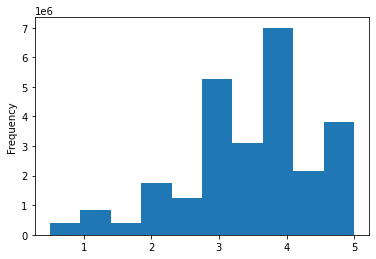

In [56]:
pd.options.display.float_format = '{:20,.2f}'.format
ratings_df['rating'].plot(kind='hist')
ratings_df['rating'].describe()

### Merge the datasets into a single DataFrame

In [57]:
movies_df = pd.merge(wiki_movies_df, kaggle_metadata_df, on='imdb_id', suffixes=['_wiki','_kaggle'])

In [58]:
movies_df.columns.tolist()

['url',
 'imdb_link',
 'title_wiki',
 'Based on',
 'Starring',
 'Cinematography',
 'Country',
 'Language',
 'Composer(s)',
 'Writers',
 'Director',
 'Editor(s)',
 'Distributor',
 'Producer(s)',
 'Production company(s)',
 'imdb_id',
 'box_office',
 'budget_wiki',
 'release_date_wiki',
 'running_time',
 'belongs_to_collection',
 'budget_kaggle',
 'genres',
 'homepage',
 'id',
 'original_language',
 'original_title',
 'overview',
 'popularity',
 'poster_path',
 'production_companies',
 'production_countries',
 'release_date_kaggle',
 'revenue',
 'runtime',
 'spoken_languages',
 'status',
 'tagline',
 'title_kaggle',
 'video',
 'vote_average',
 'vote_count']

### Review duplicate column data - decide which to use...

In [59]:
movies_df[['title_wiki','title_kaggle']]

,title_wiki,title_kaggle
0,The Adventures of Ford Fairlane,The Adventures of Ford Fairlane
1,"After Dark, My Sweet","After Dark, My Sweet"
2,Air America,Air America
3,Alice,Alice
4,Almost an Angel,Almost an Angel
...,...,...
6047,A Fantastic Woman,A Fantastic Woman
6048,Permission,Permission
6049,Loveless,Loveless
6050,Gemini,Gemini


In [60]:
movies_df[movies_df['title_wiki'] != movies_df['title_kaggle']][['title_wiki','title_kaggle']]

,title_wiki,title_kaggle
27,China Cry,China Cry: A True Story
36,Daddy's Dyin' ...Who's Got the Will?,Daddy's Dyin'... Who's Got the Will?
38,The Dark Side of the Moon,The Dark Side of The Moon
42,Delta Force 2,Delta Force 2: The Colombian Connection
48,DuckTales the Movie:Treasure of the Lost Lamp,DuckTales: The Movie - Treasure of the Lost Lamp
...,...,...
5956,Chips,CHiPS
5971,Spark,Spark: A Space Tail
5994,Pirates of the Caribbean:Dead Men Tell No Tales,Pirates of the Caribbean: Dead Men Tell No Tales
6023,Valerian and the Cityof a Thousand Planets,Valerian and the City of a Thousand Planets


In [61]:
# Show any rows where title_kaggle is empty

movies_df[(movies_df['title_kaggle'] == '') | (movies_df['title_kaggle'].isnull())]

,url,imdb_link,title_wiki,Based on,Starring,Cinematography,Country,Language,Composer(s),Writers,...,release_date_kaggle,revenue,runtime,spoken_languages,status,tagline,title_kaggle,video,vote_average,vote_count


**Drop Wikipedia title column**

<AxesSubplot:xlabel='running_time', ylabel='runtime'>

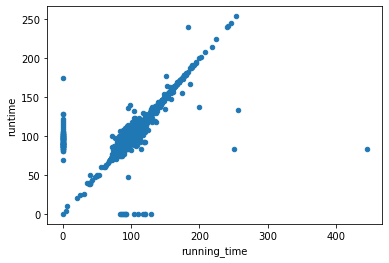

In [62]:
movies_df.fillna(0).plot(x='running_time', y='runtime', kind='scatter')

**Keep Kaggle "runtime" - fill in missing values from wikipedia data**

<AxesSubplot:xlabel='budget_wiki', ylabel='budget_kaggle'>

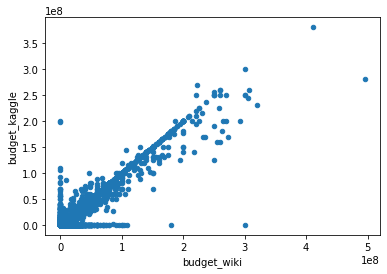

In [63]:
movies_df.fillna(0).plot(x='budget_wiki',y='budget_kaggle', kind='scatter')

**Keep Kaggle "budget" - fill in missing values from wikipedia data**

<AxesSubplot:xlabel='box_office', ylabel='revenue'>

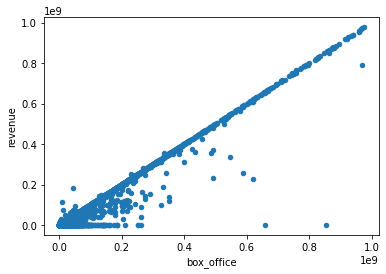

In [64]:
movies_df.fillna(0)[movies_df['box_office'] < 10**9].plot(x='box_office', y='revenue', kind='scatter')

**Keep Kaggle "revenue" - fill in missing values from wikipedia data**

<AxesSubplot:xlabel='release_date_wiki'>

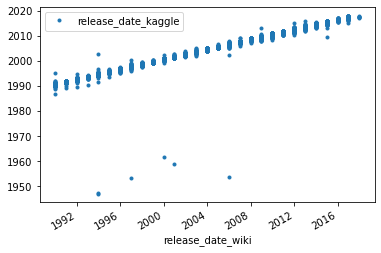

In [65]:
movies_df[['release_date_wiki','release_date_kaggle']].plot(x='release_date_wiki', y='release_date_kaggle', style='.')

In [66]:
movies_df[(movies_df['release_date_wiki'] > '1996-01-01') & (movies_df['release_date_kaggle'] < '1965-01-01')]

,url,imdb_link,title_wiki,Based on,Starring,Cinematography,Country,Language,Composer(s),Writers,...,release_date_kaggle,revenue,runtime,spoken_languages,status,tagline,title_kaggle,video,vote_average,vote_count
1680,/wiki/The_Member_of_the_Wedding_(film),https://www.imdb.com/title/tt0044896/,The Member of the Wedding,"[The Member of the Wedding, by, Carson McCullers]","[Ethel Waters, Julie Harris, Brandon De Wilde]",Hal Mohr,United States,English,Alex North,"[Edna Anhalt, Edward Anhalt]",...,1952-12-25,0.00,93.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,She became a woman in the middle of a kiss!,The Member of the Wedding,False,5.70,8.00
2295,https://en.wikipedia.org/wiki/The_Ladies_Man,https://www.imdb.com/title/tt0055069/,The Ladies Man,NaN,"[Jerry Lewis, Lillian Briggs, Helen Traubel, K...",W. Wallace Kelley,United States,English,Walter Scharf,"[Jerry Lewis, Bill Richmond]",...,1961-06-21,0.00,95.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"""He's wacky!"" - ""He's Shweet!"" - ""He's the mos...",The Ladies Man,False,7.00,20.00
2458,https://en.wikipedia.org/wiki/Earth_vs._the_Sp...,https://www.imdb.com/title/tt0051570/,Earth vs. the Spider,NaN,"[Ed Kemmer, June Kenney, Eugene Persson, Gene ...",Jack A. Marta,United States,English,Albert Glasser,"[László Görög, George Worthing Yates]",...,1958-09-01,0.00,73.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Spider will eat you alive!,Earth vs. the Spider,False,4.70,15.00
3607,https://en.wikipedia.org/wiki/The_Holiday,https://www.imdb.com/title/tt00457939/,The Holiday,NaN,"[Kate Winslet, Cameron Diaz, Jude Law, Jack Bl...",Dean Cundey,United States,English,Hans Zimmer,Nancy Meyers,...,1953-08-28,"30,500,000.00",118.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Pouring out of impassioned pages...brawling th...,From Here to Eternity,False,7.20,137.00


In [67]:
movies_df[(movies_df['release_date_wiki'] > '1996-01-01') & (movies_df['release_date_kaggle'] < '1965-01-01')].index

Int64Index([1680, 2295, 2458, 3607], dtype='int64')

In [68]:
movies_df = movies_df.drop(movies_df[(movies_df['release_date_wiki'] > '1996-01-01') & (movies_df['release_date_kaggle'] < '1965-01-01')].index)

In [69]:
movies_df[movies_df['release_date_wiki'].isnull()]

,url,imdb_link,title_wiki,Based on,Starring,Cinematography,Country,Language,Composer(s),Writers,...,release_date_kaggle,revenue,runtime,spoken_languages,status,tagline,title_kaggle,video,vote_average,vote_count


**No missing data for release dates, drop Wikipedia**

In [70]:
# Convert the 'language' column values to tuples so we can count the values.
movies_df['Language'].apply(lambda x: tuple(x) if type(x) == list else x).value_counts(dropna=False)

English                                5549
(English, Spanish)                       68
NaN                                      59
(English, French)                        35
(English, Japanese)                      25
                                       ... 
(English, Hebrew, Spanish)                1
(English, Japanese, French)               1
(English, Spanish, Apache)                1
(Syriac, Aramaic, English, Italian)       1
Russian                                   1
Name: Language, Length: 198, dtype: int64

In [71]:
movies_df['original_language'].value_counts(dropna=False)

en    5984
fr      16
es      10
it       8
de       6
ja       4
pt       4
zh       4
da       2
hi       2
sv       1
ko       1
ab       1
tr       1
he       1
ar       1
cn       1
ru       1
Name: original_language, dtype: int64

**Drop Wikipedia language column**

In [72]:
movies_df[['Production company(s)','production_companies']]

,Production company(s),production_companies
0,Silver Pictures,[{'name': 'Twentieth Century Fox Film Corporat...
1,Avenue Pictures,"[{'name': 'Avenue Pictures Productions', 'id':..."
2,"[Carolco Pictures, IndieProd Company]","[{'name': 'IndieProd Company Productions', 'id..."
3,NaN,"[{'name': 'Orion Pictures', 'id': 41}]"
4,NaN,"[{'name': 'Paramount Pictures', 'id': 4}]"
...,...,...
6047,"[Fabula, Komplizen Film]","[{'name': 'Komplizen Film', 'id': 1618}, {'nam..."
6048,Ball & Chain Productions,"[{'name': 'Ball & Chain Productions', 'id': 74..."
6049,"[Arte France Cinéma, Why Not Productions]","[{'name': 'ARTE France Cinéma', 'id': 94}, {'n..."
6050,"[Film Science, Rough House Pictures, Syncopate...","[{'name': 'Film Science', 'id': 1976}, {'name'..."


**Drop Wikipedia Production company column**

### Clean the merged DataFrame

In [73]:
# Drop the un-needed duplicate columns

movies_df.drop(columns=['title_wiki','release_date_wiki','Language','Production company(s)'], inplace=True)

In [74]:
def fill_missing_kaggle_data(df, kaggle_column, wiki_column):
    df[kaggle_column] = df.apply(
        lambda row: row[wiki_column] if row[kaggle_column] == 0 else row[kaggle_column]
        , axis=1)
    df.drop(columns=wiki_column, inplace=True)

In [75]:
# Use the function to leverage wiki data for Kaggle zero values.
fill_missing_kaggle_data(movies_df, 'runtime', 'running_time')
fill_missing_kaggle_data(movies_df, 'budget_kaggle', 'budget_wiki')
fill_missing_kaggle_data(movies_df, 'revenue', 'box_office')
movies_df.head(3)

,url,imdb_link,Based on,Starring,Cinematography,Country,Composer(s),Writers,Director,Editor(s),...,release_date_kaggle,revenue,runtime,spoken_languages,status,tagline,title_kaggle,video,vote_average,vote_count
0,https://en.wikipedia.org/wiki/The_Adventures_o...,https://www.imdb.com/title/tt0098987/,"[Characters, by Rex Weiner]","[Andrew Dice Clay, Wayne Newton, Priscilla Pre...",Oliver Wood,United States,"[Cliff Eidelman, Yello]","[David Arnott, James Cappe, Daniel Waters]",Renny Harlin,Michael Tronick,...,1990-07-11,"20,423,389.00",104.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Kojak. Columbo. Dirty Harry. Wimps.,The Adventures of Ford Fairlane,False,6.20,72.00
1,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",https://www.imdb.com/title/tt0098994/,"[the novel, After Dark, My Sweet, by, Jim Thom...","[Jason Patric, Rachel Ward, Bruce Dern, George...",Mark Plummer,United States,Maurice Jarre,"[James Foley, Robert Redlin]",James Foley,Howard E. Smith,...,1990-08-24,"2,700,000.00",114.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,All they risked was everything.,"After Dark, My Sweet",False,6.50,17.00
2,https://en.wikipedia.org/wiki/Air_America_(film),https://www.imdb.com/title/tt0099005/,"[Air America, by, Christopher Robbins]","[Mel Gibson, Robert Downey Jr., Nancy Travis, ...",Roger Deakins,United States,Charles Gross,"[John Eskow, Richard Rush]",Roger Spottiswoode,"[John Bloom, Lois Freeman-Fox]",...,1990-08-10,"33,461,269.00",112.00,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The few. The proud. The totally insane.,Air America,False,5.30,146.00


In [76]:
# Convert lists to tuples so we can count values.
for col in movies_df.columns:
    lists_to_tuples = lambda x: tuple(x) if type(x) == list else x
    value_counts = movies_df[col].apply(lists_to_tuples).value_counts(dropna=False)
    num_values = len(value_counts)
    if num_values == 1:
        print(col)

In [77]:
movies_df = movies_df.loc[:, ['imdb_id','id','title_kaggle','original_title','tagline','belongs_to_collection','url','imdb_link',
                       'runtime','budget_kaggle','revenue','release_date_kaggle','popularity','vote_average','vote_count',
                       'genres','original_language','overview','spoken_languages','Country',
                       'production_companies','production_countries','Distributor',
                       'Producer(s)','Director','Starring','Cinematography','Editor(s)','Writers','Composer(s)','Based on'
                      ]]

In [78]:
movies_df.rename({'id':'kaggle_id',
                  'title_kaggle':'title',
                  'url':'wikipedia_url',
                  'budget_kaggle':'budget',
                  'release_date_kaggle':'release_date',
                  'Country':'country',
                  'Distributor':'distributor',
                  'Producer(s)':'producers',
                  'Director':'director',
                  'Starring':'starring',
                  'Cinematography':'cinematography',
                  'Editor(s)':'editors',
                  'Writer(s)':'writers',
                  'Composer(s)':'composers',
                  'Based on':'based_on'
                 }, axis='columns', inplace=True)

### Ratings Data review and cleaning

In [83]:
# Group and count the ratings so the data is easier to manage - reduces the size of the dataset.

rating_counts = ratings_df.groupby(['movieId','rating'], as_index=False).count() \
                .rename({'userId':'count'}, axis=1) \
                .pivot(index='movieId',columns='rating', values='count')

In [84]:
# Rename the rating columns so we know the data source after creating a joined table.

rating_counts.columns = ['rating_' + str(col) for col in rating_counts.columns]

In [87]:
# left-join the DataFrames to keep all the movies, and apply relevant ratings for those movies.

movies_with_ratings_df = pd.merge(movies_df, rating_counts, left_on='kaggle_id', right_index=True, how='left')

In [88]:
movies_with_ratings_df[rating_counts.columns] = movies_with_ratings_df[rating_counts.columns].fillna(0)